## Описание проекта<a name="0."></a>

Вы работаете в интернет-магазине <b>«Стримчик»</b>, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, <b>Xbox</b> или <b>PlayStation</b>). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br/><br/>
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.<br/><br/>
В наборе данных попадается аббревиатура <b>ESRB (Entertainment Software Rating Board)</b> — это ассоциация, определяющая возрастной рейтинг компьютерных игр. <b>ESRB</b> оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».|

## Описание данных

* <b>Name</b> — название игры
* <b>Platform</b> — платформа
* <b>Year_of_Release</b> — год выпуска
* <b>Genre</b> — жанр игры
* <b>NA_sales</b> — продажи в Северной Америке (миллионы долларов)
* <b>EU_sales</b> — продажи в Европе (миллионы долларов)
* <b>JP_sales</b> — продажи в Японии (миллионы долларов)
* <b>Other_sales</b> — продажи в других странах (миллионы долларов)
* <b>Critic_Score</b> — оценка критиков (максимум 100)
* <b>User_Score</b> — оценка пользователей (максимум 10)
* <b>Rating</b> — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

<b>Импортируем библиотеки:</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

## Шаг 1. Ознакомление с данными

Посмотрим что нам досталось:

In [2]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
games.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<br/><b>1.1. Общая информация о датафрейме.</b><br/>

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Присутствуют пропуски, кое-где их слишком много


<br/><b>1.2. В каких столбцах меняем типы данных.</b><br/>
  
* <b>user_score</b> - это же численный показатель, а имеет тип <b>object</b> - меняем на <b>'float'</b>.
* <b>Year_of_Release  </b> - это целое число, а имеет тип <b>float64</b> - меняем на <b>'int'</b>.
<br/>
Остальное ок.

<br/><a name="1.3."></a>
<b>1.3. Информация о пропусках, методы их заполнения.</b><br/>

Узнаем сколько у нас пропусков в датасете:




In [5]:
display(games.isna().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Что делать?
* <b>critic_score</b> - <b>оценка критиков </b> - пропусков много, удалить мы не можем, это важные данные. Причиной вполен аозможно стало то, что игры эти просто не оценивали так, как это не было принято. Заполнить медианными или средними значениями тоже нельзя, вся картина исказится. Выберем значением, которе было разительно отличалось от уже представленных. например "-1", так как самая плохая оценка это ноль и ниже уже некуда.
* <b>user_score</b> - скорее всего отсутствие сервисов по оценке игр пользователями в давние времена и является причиной отстуствия оценки. 
Сделаем как и с <b>critic_score</b>.
* <b>rating</b> - <b>рейтинг от  ESRB</b> - Данная организация появилась лишь в 1994 году, а у нас есть игры и выпущенные раньше. Поставим рейтинг "Unknown";
* <b>Name</b><b>Year_of_Release</b> и <b>Genre</b> пропущенных значений мало, просто удалим их

## Шаг 2. Подготовка данных<a name="2."></a>

<br/><b>2.1. Для удобства работы приведем названия столбцов к нижнему регистру:</b><br/>

In [6]:
games.columns = games.columns.str.lower()

<br/><b>2.2. Изменение типа данных по столбцу user_score</b>.<br/>

В столбце <b>user_score</b> - есть странные значения:

In [7]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Есть пропуски NaN, но и <b>"tbd"</b>, это означает что оценок было слишком мало, <b>To Be Determined</b>, то есть фактически это тоже NaN, посмотрим сколько их:

In [8]:
games[games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Для замены типа данных на float надо избавится NaN и tbd, заменим их на значение "-1".

In [9]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

<br/><b>2.3. Обработка пропусков</b>:<br/>

Столбцы <b>critic_score</b> и <b>user_score</b> - заполним пропуски значением -1.

In [10]:
games['critic_score'] = games['critic_score'].fillna(-1)
games['user_score'] = games['user_score'].fillna(-1)

In [11]:
print('Пропуски в critic_score - {}'.format(games['critic_score'].isnull().sum()))
print('Пропуски в user_score - {}'.format(games['user_score'].isnull().sum()))

Пропуски в critic_score - 0
Пропуски в user_score - 0


In [12]:
games['rating'] = games['rating'].fillna('unknown')

Обновим статистику пропусков:



In [13]:
display(games.isna().sum())

name                 2
platform             0
year_of_release    269
genre                2
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
dtype: int64

Остальное можно удалить, процент их незначителем от общего и повлиять на итоговые рузультаты они не смогут.

In [14]:
games = games.dropna(subset = ['name', 'year_of_release', 'genre'])

In [15]:
display(games.isna().sum())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Идеально, пропусков нет.

<br/><b>2.4. Отдельный столбец с суммой продаж по всем регионам 'sales_total'</b>:<br/>

In [16]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Шаг 3. Исследовательский анализ данных<a name="2."></a>

<br/>
<b>3.1. Количество выпущенных игр по годам</b>:<br/>

Посмотрим, сколько игр выпускалось в каждый из представленных в наших данных годов:

Text(0.5, 0, 'Год выпуска')

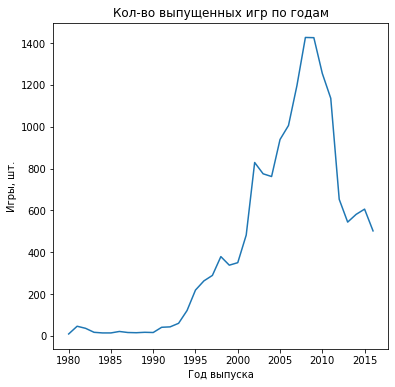

In [17]:
count_by_year = games.groupby('year_of_release')['name'].count()
count_by_year.plot(figsize=(6, 6), title='Кол-во выпущенных игр по годам')
ax = plt.gca()
ax.set_ylabel('Игры, шт.')
ax.set_xlabel('Год выпуска')


Напрашивается вывод: до 1994 года игр выпускалось мало, компьютеры считались инструментом для работы, а глобальных приставок не было. Последующий рост обусловлен выходом первой плойки и более дружелюбной Win95. Дальшейшие всплекски роста совпадают с выходами новых консолей. Резкий спад 2012 года скорее всего связан с развитием мобильного гейминга, который не отражен в наших данных.

<br/><b>3.2 Количество выпущенных игр по платформам</b>.<br/>

Посмотрим на то, сколько игр выпускалось на каждую платформу за весь анализируемый период:

In [18]:
games.query('year_of_release > 1984').pivot_table(index='platform', columns='year_of_release', values='name', aggfunc='count', fill_value='-')


year_of_release,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,1,2,6,2,2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3DO,-,-,-,-,-,-,-,-,-,1,2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3DS,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,116,93,91,80,86,46
DC,-,-,-,-,-,-,-,-,-,-,-,-,-,7,14,20,8,1,-,-,-,-,1,1,-,-,-,-,-,-,-,-
DS,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,23,118,201,376,492,403,323,153,23,8,-,-,-
GB,-,-,-,1,10,3,9,7,-,3,4,6,8,8,11,17,10,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
GBA,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,107,198,150,175,135,39,6,-,-,-,-,-,-,-,-,-
GC,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,22,152,144,83,97,40,4,-,-,-,-,-,-,-,-,-
GEN,-,-,-,-,-,1,1,6,7,12,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


По этой табличке мы наглядно понимаем когда и сколько "жила" та или иная платформа, естественно что если платформа живет долго - то игр больше получает.

<br/><b>3.3 Динамика продаж игр по платформам</b>.<br/>

In [19]:
def year_sales(games, platform, year_begin, year_end, title):
    plt.figure(figsize=(25,12))
    plt.title(title)
    plt.xlabel('Год')
    plt.ylabel('Продажи, млн')
    
    for name in platform: 
        plt.plot(games[(games['year_of_release'] >= year_begin) & (games['year_of_release'] <= year_end) & (games['platform'] == name)]
                 .groupby('year_of_release')['sales_total'].sum(), 'o-', label=name
                )
    
    plt.legend(loc="upper left")
    plt.show()

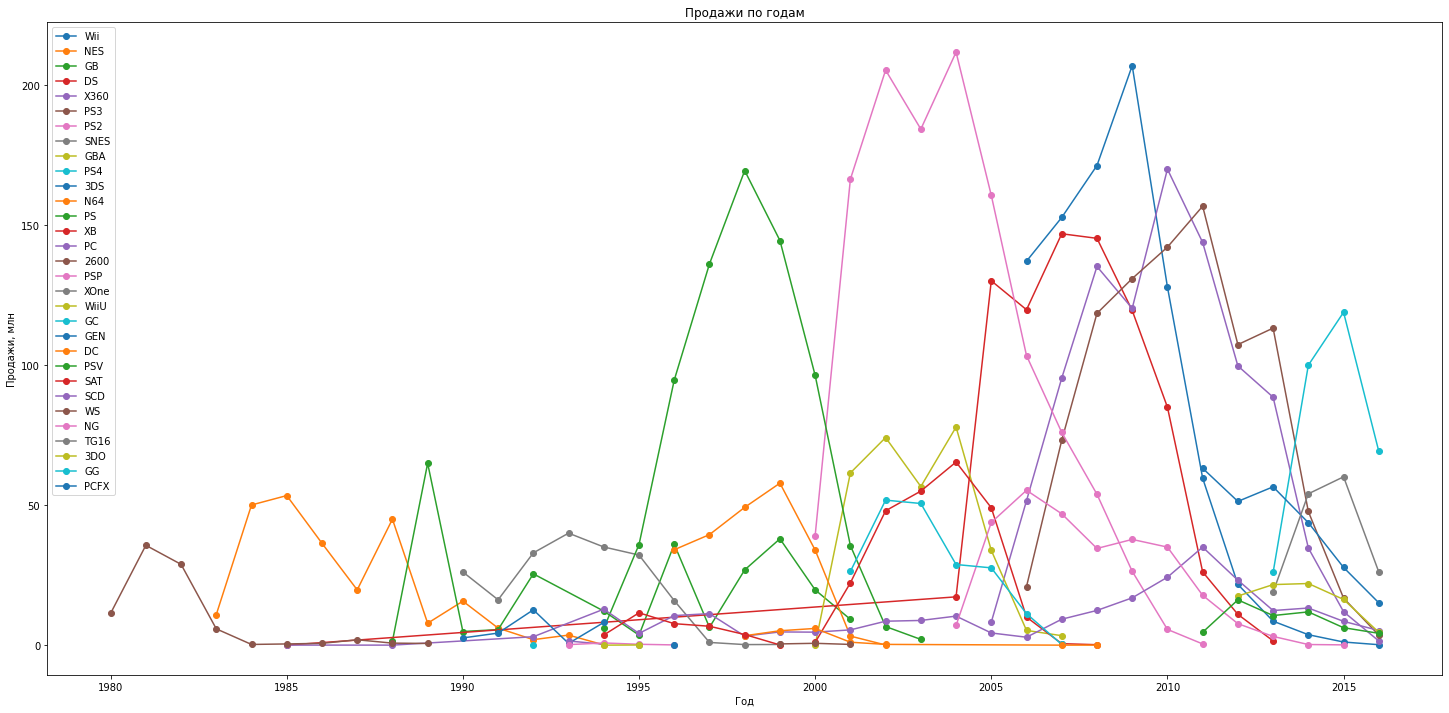

In [20]:
year_sales(games, games['platform'].unique(), 1980, 2016,'Продажи по годам')

Тут все очевидно, самые известные консоли являются лидерами, в Отстающих - консоли японского локального рынка, в остальном ммире о них мало что вообще слышали. Разобьем график на части: топовые платформы, средние и отсталые

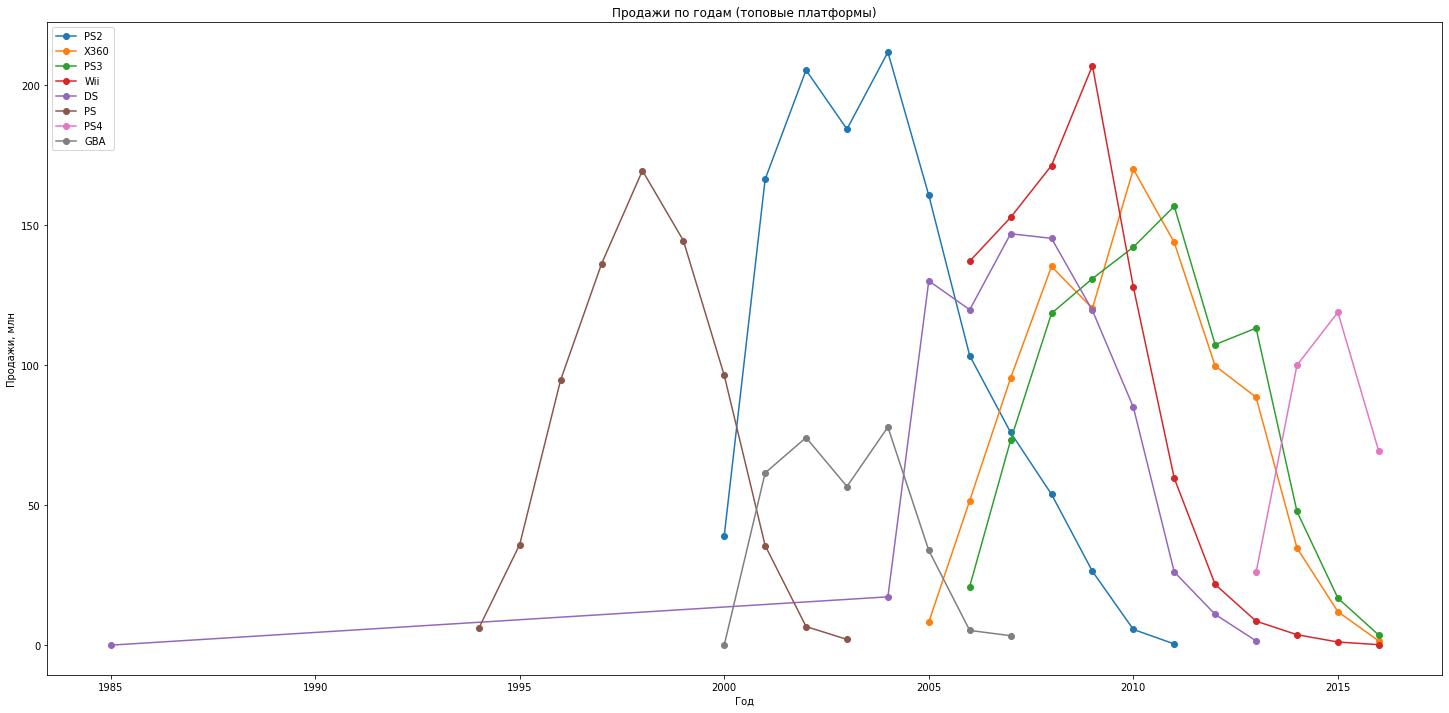

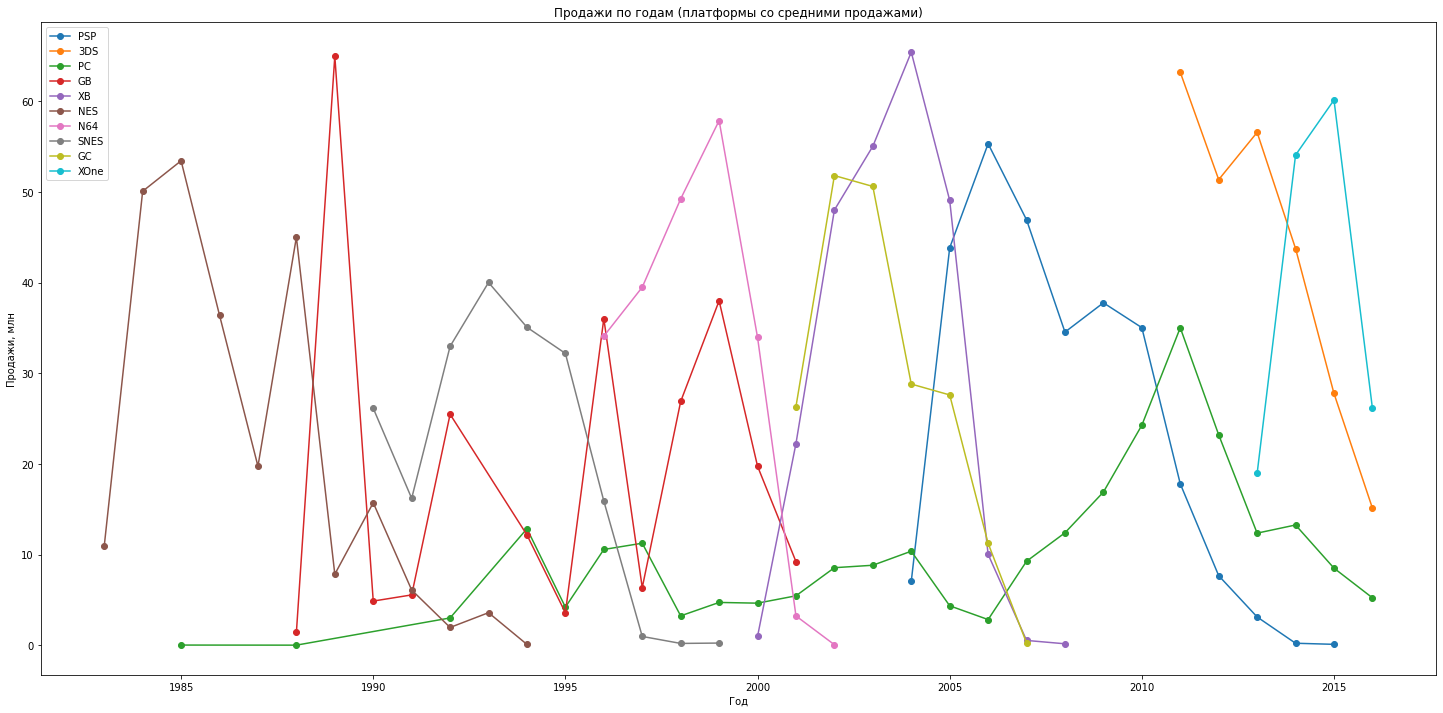

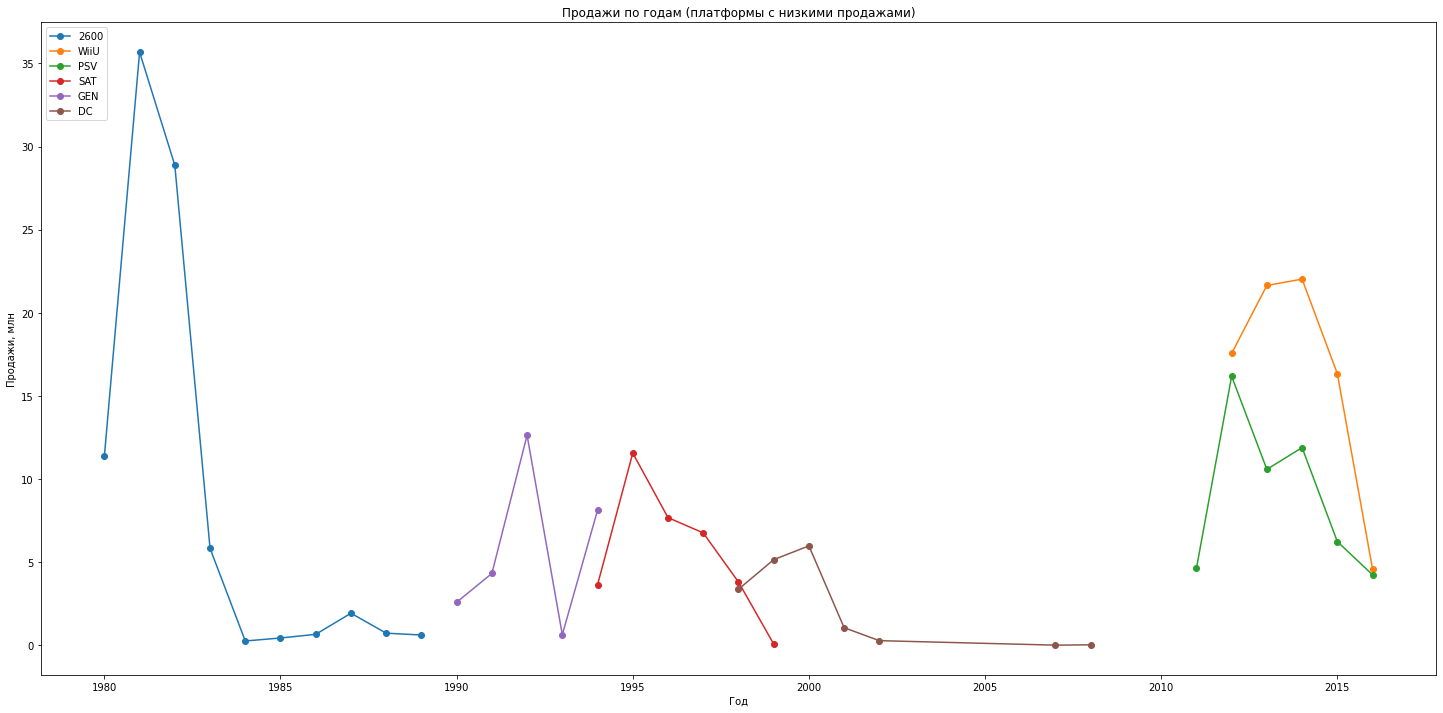

In [21]:
top_platforms = games.groupby('platform')['sales_total'].sum().reset_index()
top_platforms.sort_values(by='sales_total', ascending=False, inplace=True)
top_platforms.reset_index(inplace=True)


year_sales(games, top_platforms.head(8)['platform'].values, 1980, 2016,'Продажи по годам (топовые платформы)')
year_sales(games, top_platforms.loc[8:17,'platform'].values, 1980, 2016,'Продажи по годам (платформы со средними продажами)')
year_sales(games, top_platforms.loc[18:23,'platform'].values, 1980, 2016,'Продажи по годам (платформы с низкими продажами)')

Выберем топ платформ, по которым были самые большие суммарные продажи игр за весь рассматриваемый период:

In [22]:
games.groupby('platform')['sales_total'].sum().to_frame('sales_total').sort_values(by='sales_total', ascending=False).head(10)

,sales_total
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


<br/><b>График динамики продаж по годам по топ-6 платформ:</b></br><br/>

Посмотрим, сколько "живут" консоли.<br/>
* PS - прожила с 1994 года до 2003, почти 10 лет;
* PS2 - с 2000 до 2011 года - 11 лет;
* PS3 - с 2006 по настоящее время ещё живёт, но начала сильно сдавать позиции с выходом в 2013 году PS4;
* DS - вышла в 1985, потом вообще нет данных, скорее всего, по той причине, что они не собирались. И с 2004 года популярность стала расти, пик в 2008, конец срока службы - 2013 год - 8 активных лет жизни;
* Wii - с 2006 по нынешний день, но в 2016 уже почти изжила себя - опять 10 лет.

Таким образом, в среднем консоль живет 10 лет. И жила бы больше, если б не выходили более новые консоли. Но это неизбежно, т.к. прогресс идет вперед и "железо" в старых консолях перестает отвечать техническим требованиям новых игр.

<br/><b>3.4 Динамика продаж игр в наше время</b>.<br/>

Выделим актуальные на данный момент платформы, т.е. платформы стартовавшие относительно недавно и находящиеся в данный момент на подъёме. Судя по графику, это PS4 и XOne, вышедшие в 2013г.  
2016 год смотреть на графике не будем, т.к. данные по нему не полные


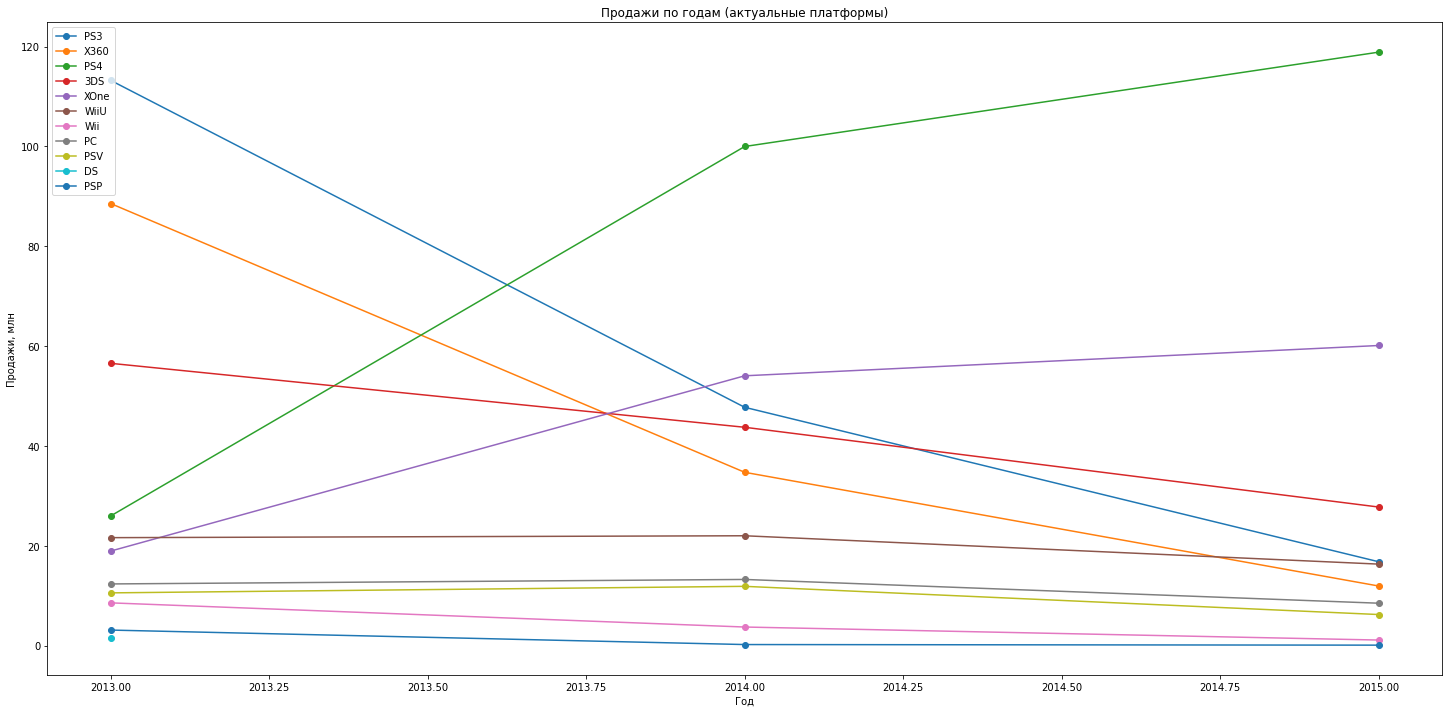

In [23]:
games_relevant = games.query('2013 <= year_of_release <= 2016')

year_sales(games_relevant, games_relevant['platform'].unique(), 2013, 2015,'Продажи по годам (актуальные платформы)')

На конец 2016 года лидируют по продажам следующие платформы:
* <b>PS4</b>;
* <b>Xone</b>;
* <b>3DS</b>.

Это топ-3. Причем, исходя из данных, количество продаж игр, выпущенных на каждую из этих платформ, снижается. Таким образом, можно сказать, что весь рынок игр падает.

<br/><b>3.5 Boxplot по глобальным продажам игр и с разбивкой по платформам</b>.<br/>

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Оценим разницу в продажах и в средних продажах на разных платформах.

<br/>
<b>3.5.1. Функция для прорисовки boxplot </b>.<br/>

In [24]:
def create_any_sales_boxplot(title=None, query_condition = None, ylims=None):
    %matplotlib inline
    if query_condition == None:
        ax = games.boxplot(column='sales_total', fontsize=25, figsize=(25,10),
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5), 
                                         notch=True)
    else:
        df_query = games.query(query_condition)
        by_column = query_condition.split()[0]
        ax = df_query.boxplot(column='sales_total', by=by_column, fontsize=25, figsize=(25,10),
                                         boxprops=dict(linestyle='-', linewidth=5),
                                         medianprops=dict(linestyle='-', linewidth=5),
                                         whiskerprops=dict(linestyle='-', linewidth=5),
                                         capprops=dict(linestyle='-', linewidth=5),
                                         notch=True)
        ax.set_xlabel('')
        ax.set_title('')
    if ylims != None:
        ax.set_ylim(ylims)
    if title != None:
        plt.suptitle(title, y=0.94, fontsize=25, fontweight='bold')

<br/><b>3.5.2. Boxplot по глобальным продажам игр</b>.<br/>

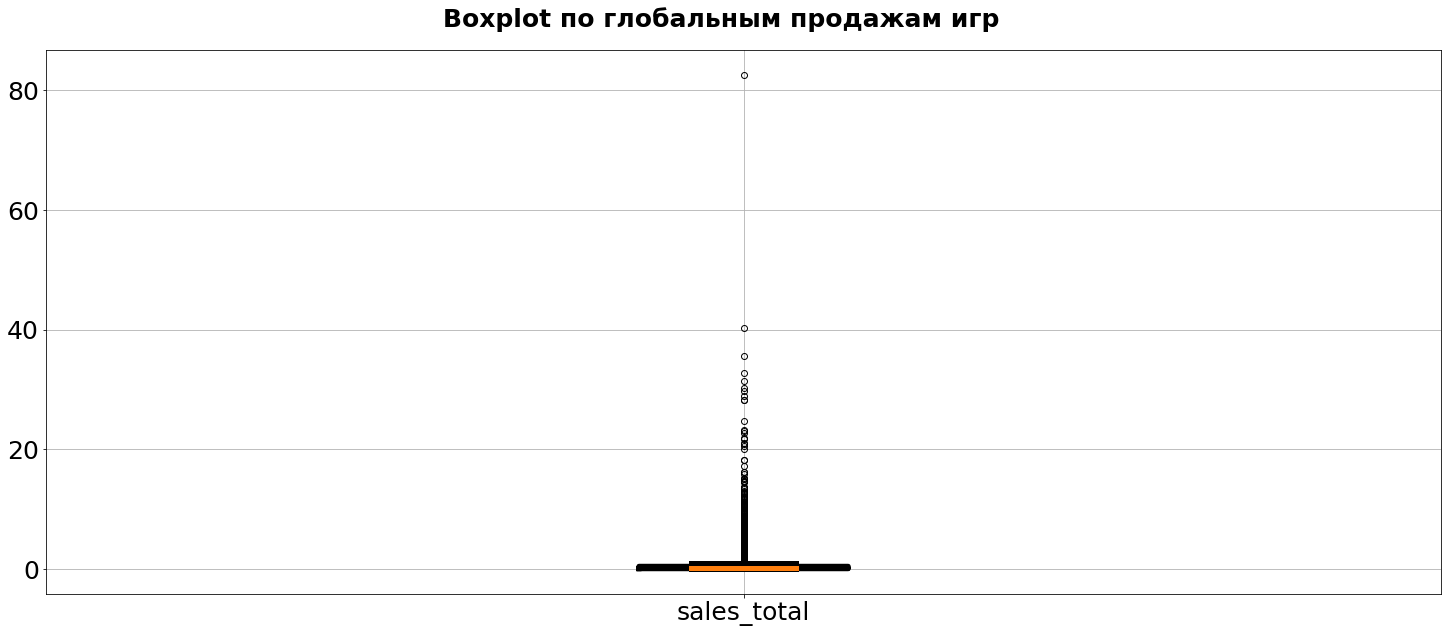

In [25]:
create_any_sales_boxplot('Boxplot по глобальным продажам игр')

Посмотрим ближе:

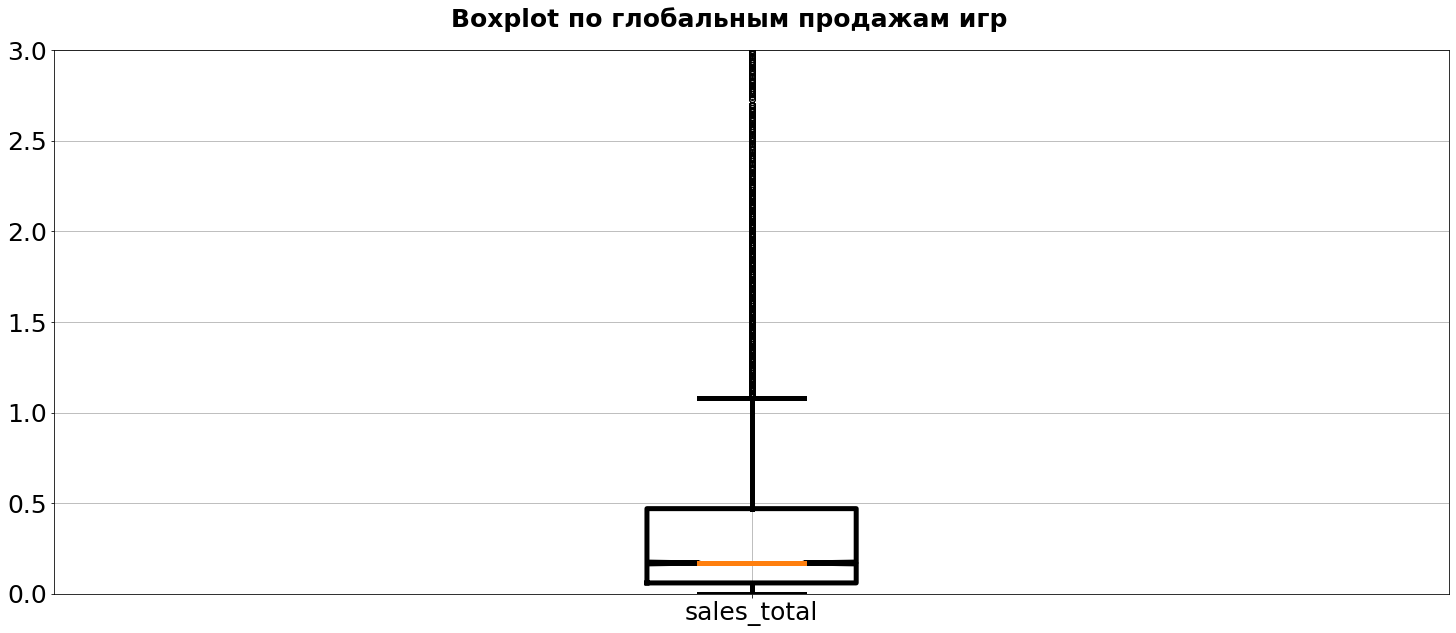

In [26]:
create_any_sales_boxplot('Boxplot по глобальным продажам игр', ylims=[0,3])

В среднем, продажи игр составляют до 1,2 млн долларов. Медиана - 0,2 миллиона долларов. Не сказать, что это много.

<br/><b>3.5.3. Boxplot по наиболее популярным на конец 2016 года платформам</b>.<br/>

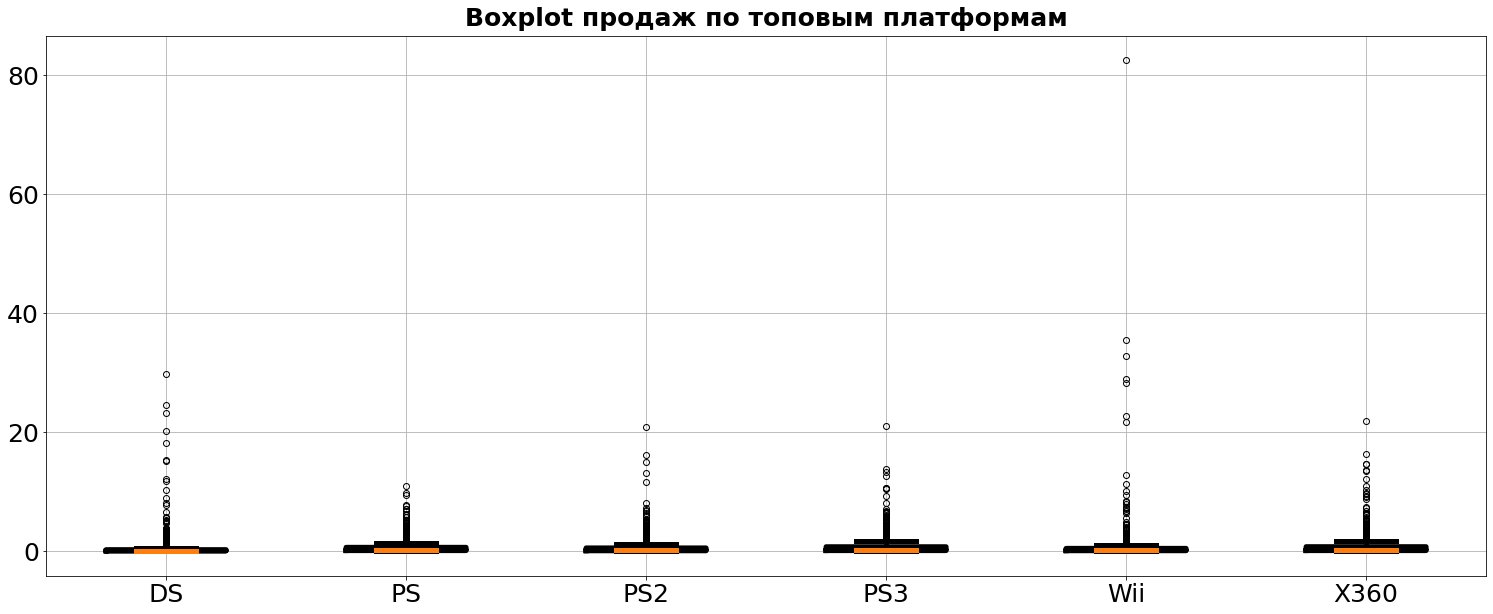

In [27]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
create_any_sales_boxplot('Boxplot продаж по топовым платформам', query_condition="platform in @top_platforms")

Посмотрим ближе:

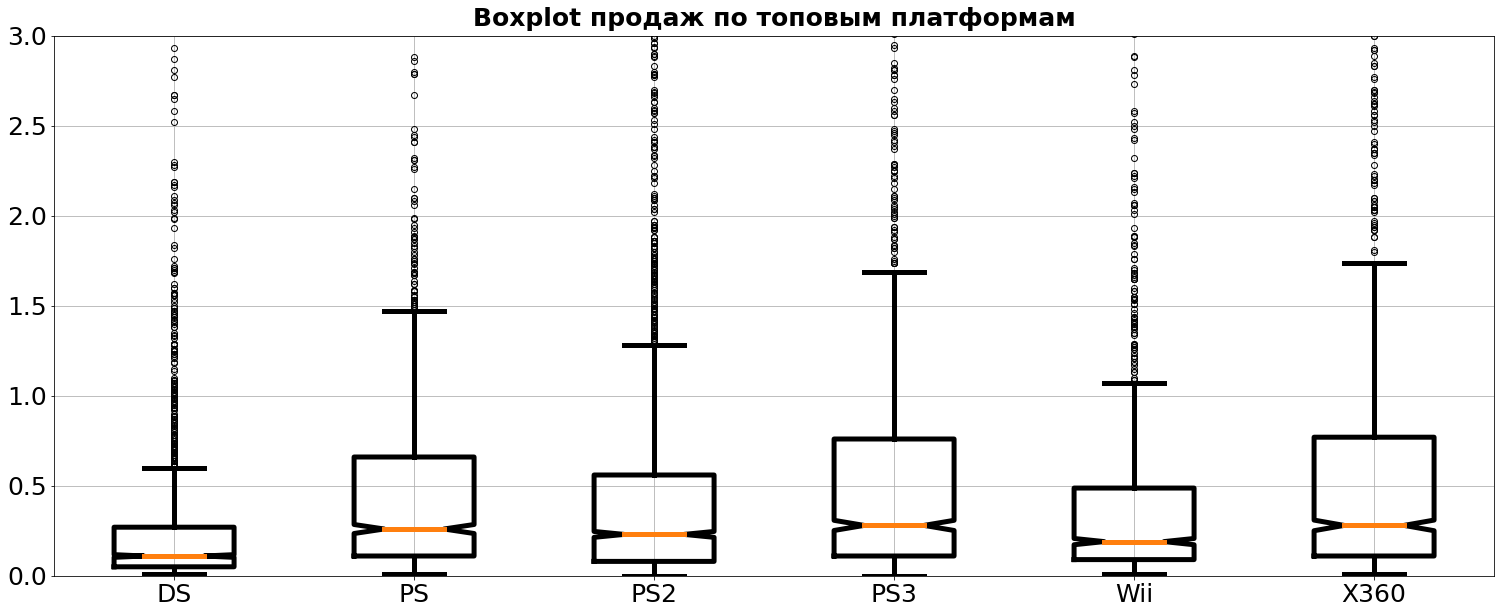

In [28]:
create_any_sales_boxplot('Boxplot продаж по топовым платформам', query_condition="platform in @top_platforms", ylims=[0,3])

Медиана по топовым платформам варьируется от 0,2 до 0,25 млн долларов прибыли за игру.<br/>
Верхняя граница предела, за которыми уже определяются аномалии, у двух платформ - PS3 и X360 - на уровне 1,7 млн долларов.<br/>
У остальных - от 1 до 1,5 миллионов долларов.<br/>
Среди всех выделяется Nintendo DS - у него эти показатели сильное ниже. Медиана < 0,1 миллиона долларов, верхняя граница - 0,6 млн. 

<br/><b>3.6 Влияние отзывов пользователей и критиков на продажи</b>.<br/>

За образец возьмем PS3 - она давно на рынке, по ней много данных, при этом даже на конец 2016 года она является одной из самых популярных игровых платформ.

In [29]:
games_ps3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0)].copy()

<br/><b>3.6.1. Диаграмма рассеяния зависимости общей суммы продаж игры от отзывов критиков</b>:<br/>

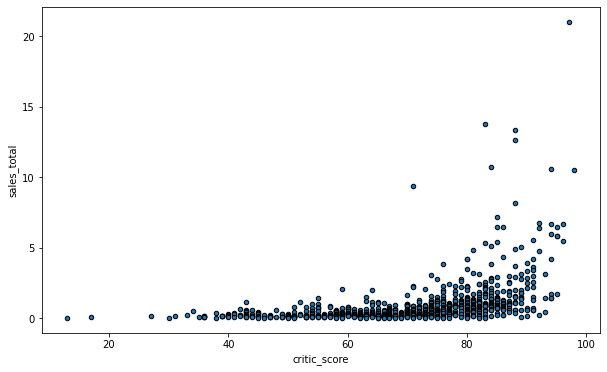

In [30]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

games_ps3 = games[(games['platform'] == 'PS3') & (games['critic_score'] > 0)].copy()
games_ps3.plot(kind='scatter', x='critic_score', y='sales_total', ec='black', figsize=(10,6))
plt.show()

С увеличением среднего рейтинга критиков увеличивается и средний уровень выручки с продажи игр, что логично: чем качественнее игра, тем больше денег она приносит разработчику и издателю.

Теперь от отзывов пользователей:

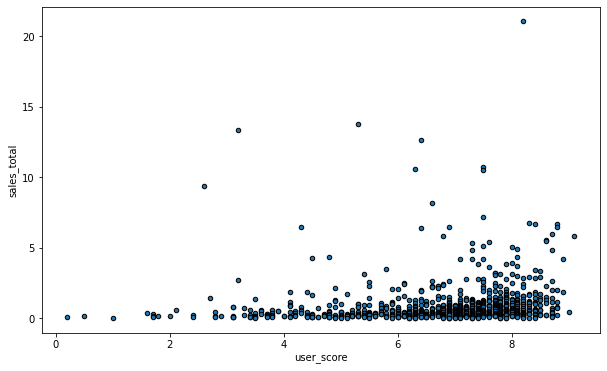

In [31]:
games_ps3 = games[(games['platform'] == 'PS3') & (games['user_score'] > 0)].copy()
games_ps3.plot(kind='scatter', x='user_score', y='sales_total', ec='black', figsize=(10,6))
plt.show()

Точно такая же картина, правда так называемых выбросов больше - когда рейтинг пользователей не велик, но тем не менее игра собирает большие деньги.  
Возможня причина - ностальгия по тсарым играм и неудачные ремейки - например Need for Speed или Call of Duty, старые названия привдекают, даже если игра не совсем удалась.

<br/><b>3.6.2. Матрица корреляции</b>:<br/>

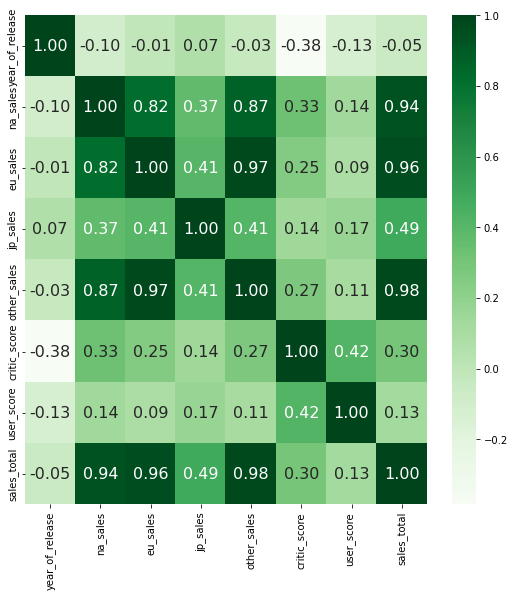

In [32]:
plt.figure(figsize=(9,9))
sns.heatmap(games_ps3.corr(), annot=True, cmap="Greens", fmt='.2f', annot_kws={'size':16})
plt.show()

Выделим нужные нам данные:

In [33]:
games_ps3_filtered = games_ps3[['sales_total' ,'critic_score', 'user_score']]

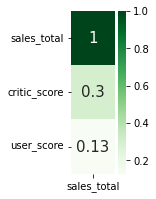

In [34]:
plt.figure(figsize=(1,3))
sns.heatmap(games_ps3_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':15})
plt.show()

Сильнее всего на конечную стоимость влияет оценка критиков. Сильнее меньше, практически не влияет - оценка пользователей.

<br/><b>3.6.3. Данные по корреляции по топовым платформам:</b><br/>

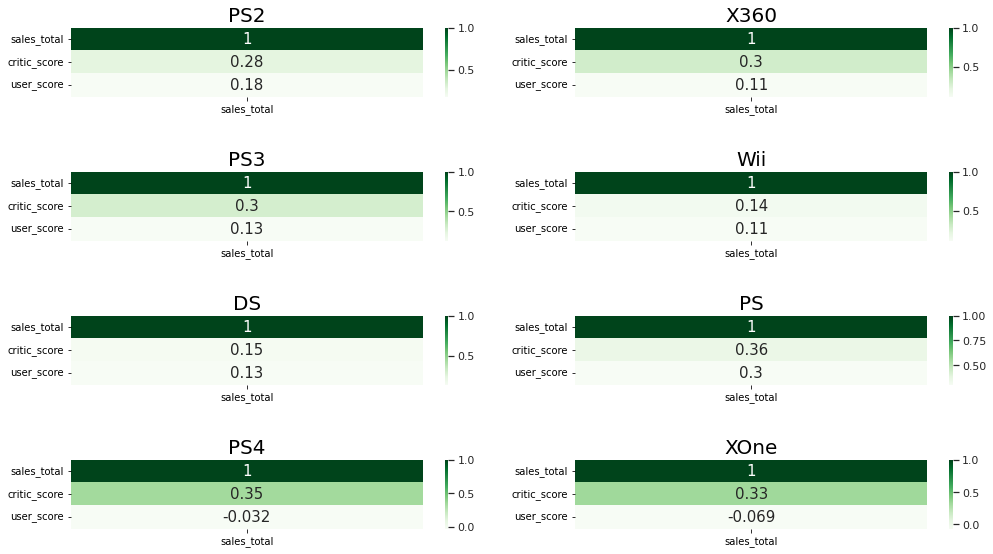

In [35]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'XOne']

rows = len(top_platforms) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,8.5))
count = 0
for r in range(rows):
    for c in range(cols):
        curr_platform = top_platforms[count]
        df_prep = games[(games['platform'] == curr_platform) & (games['user_score'] > 0)].copy()
        
        df_filtered = df_prep[['sales_total' ,'critic_score', 'user_score']]
        sns.set(font_scale=1.0)
        ax = sns.heatmap(df_filtered.corr()[['sales_total']].sort_values(by='sales_total', ascending=False), 
                         cmap="Greens", annot=True, annot_kws={'size':15}, ax=axes[r,c])
        ax.set_title(curr_platform, fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.tight_layout(pad=3)
        count += 1

Данные по корреляции между выручкой и оценкой по платформам <b>PS2, X360, PS3, PS</b> и <b>XOne</b> более или менее совпадает с общими данными по датафрейму.<br/>
Выделяются <b>Wii</b> и <b>DS</b>, по которым зависимость не такая большая.<br/>
Кстати, есть платформы, где оценка критиков, согласно данных, сильнее "определяет" конечную выручку продукта, чем оценка пользователей. Это платформы <b>DS, PS4</b> и <b>Xone</b>. В случае с <b>DS</b> полагаю, что дело в том, что приставка азиатская, большую популярность она имеет там, соответственно, далеко не большая часть игроков принимает участие в оценке игр на эту платформу. Про <b>PS4</b> и <b>Xone</b> - платформы довольно новые, вполне вероятно, что пользователи пока не "освоились", поэтому большого количества отзывов, особенно качественных от них нет.

<br/><b>3.7 Распределение игр по жанрам</b>.<br/>

Нарисуем столбчатую диаграмму с количеством и общей суммой продаж и расскажем о самых прибыльных жанрах, а потом посмотрим на особенности жанров с высокими и низкими продажами.

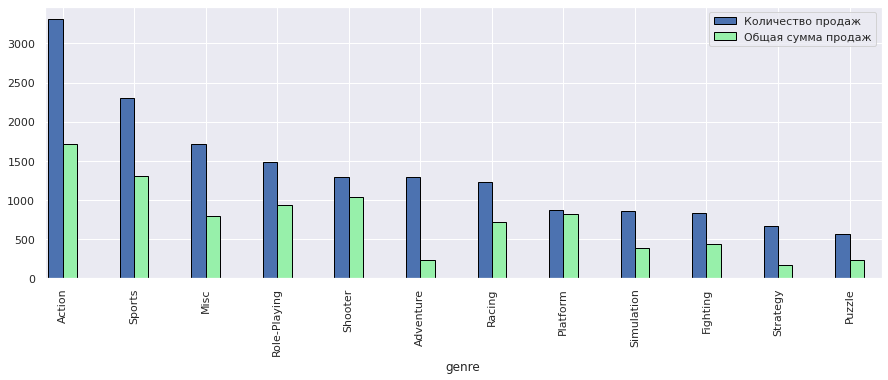

In [36]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sales_total': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1)

plot2 = pivot['sales_total']
plot2.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#97F0AA', position=0)

ax.legend(['Количество продаж', 'Общая сумма продаж'])
plt.show()

Больше всего игр жанра <b>Action</b>. За ними идут игры спортивного жанра. Причем даже учитывая то, что игр жанра "Спорт" заметно меньше на рынке (на треть от <b>Action</b>), выручка от продаж у них практически одинаковая. Это значит, что спортивные игры, в среднем, стоят дороже, чем шутеры. Ну и это ожидаемо, шутеры выходят преимущественно на ПК, тогда как спортивные игры - на консолях.<br/><br/>


Опишем отдельно топ по количеству продаж и топ по сумме выручки.<br/><br/>

<b>Количество проданных копий:</b>
1. <b>Action</b>
2. <b>Спортивный жанр</b>
3. Игры "смешанного" жанра - <b>Miscellaneous</b>

...<b>аутсайдеры</b> - игры, которые требуют усидчивости:<br/><br/>
-1. Паззлы.<br/>
-2. Стратегии.<br/><br/>

<b>Сумма выручки:</b>
1. <b>Action</b>
2. <b>Спортивный жанр</b>
3. <b>Шутеры</b>

...<b>аутсайдеры</b> почти те же герои:<br/>
-1. Стратегии.<br/>
-2. Приключенские игры.<br/>
-3. Паззлы.

## Шаг 4. Портрет пользователя регионов NA, EU, JP

Определим для пользователя каждого региона (NA, EU, JP):
* самые популярные платформы (топ-5), опишем различия в долях продаж;
* самые популярные жанры (топ-5), поясним разницу;
* определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

<br/><b>4.1. Функция для прорисовки графиков top_in_regions_plot:</b>.<br/>

In [37]:
def top_in_regions_plot(groupby, region_sales, ax):
    pivot = games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

<br/><b>4.2. Определение самых популярных платформ в заданных регионах:</b>.<br/>

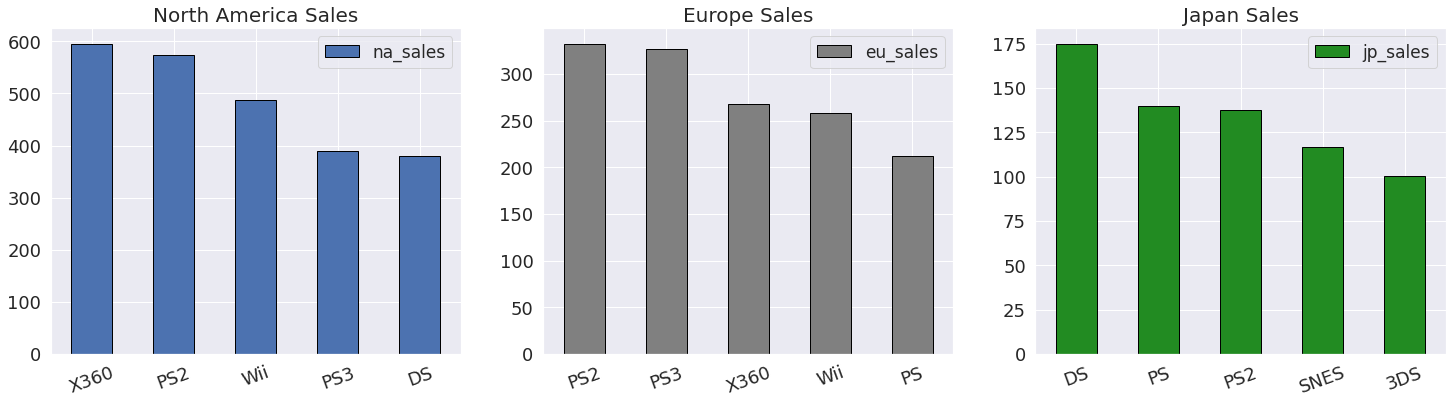

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('platform', 'na_sales', 0)
top_in_regions_plot('platform', 'eu_sales', 1)
top_in_regions_plot('platform', 'jp_sales', 2)

В <b>Северной Америке</b> имеют(имели) бешеную популярность приставки прошлого поколения <b>X360</b> и <b>PS2</b>. Немного отстает <b>Wii</b>. Топ-4 и топ-5 - <b>PS3</b> и <b>DS</b> соответственно.<br/><br/>
В <b>Европе</b> одинаково (были) популярны <b>PS2</b> и <b>PS3</b>. За ними <b>X360</b>, <b>Wii</b> и <b>PS</b>.<br/><br/>
В <b>Японии</b>, как обычно, всё наоборот. Лидер - <b>DS</b>. За ними американские <b>PS и <b>PS2</b>. Далее чисто японские <b>SNES и <b>3DS</b>.

<br/><b>4.3. Определение самых популярных жанров в заданных регионах:</b><br/>

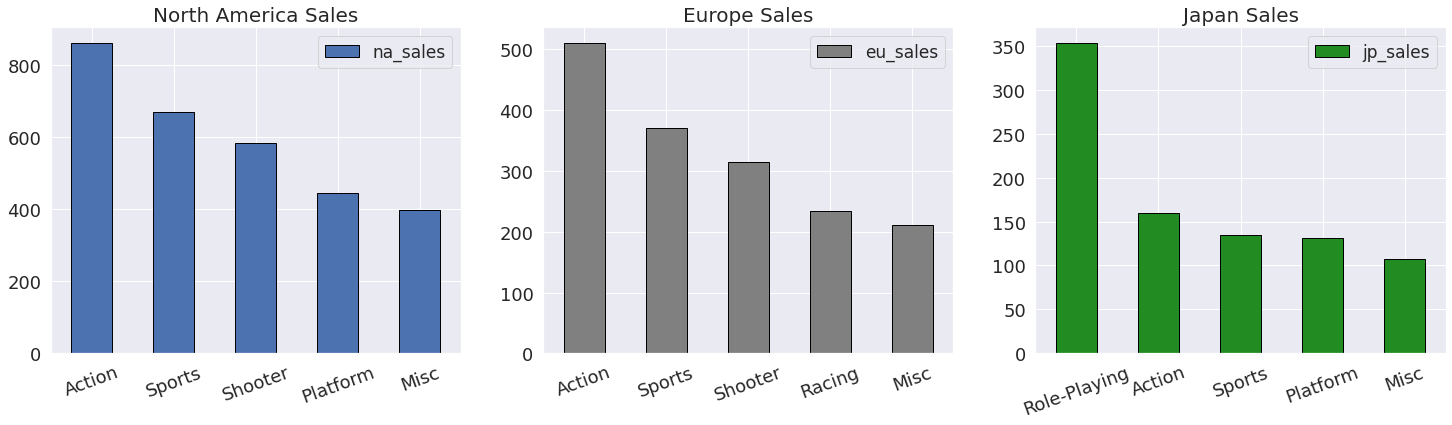

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('genre', 'na_sales', 0)
top_in_regions_plot('genre', 'eu_sales', 1)
top_in_regions_plot('genre', 'jp_sales', 2)

Вкусы в <b>Северной Америке</b> и <b>Европе</b> схожи: и там, и там живут фанаты <b>экшнов</b>, <b>спортивных игр</b> и <b>шутеров</b>. В <b> Северной Америке</b> больше играют в <b>платформеры</b>, в Европе же чаще выбирают <b>гонки</b>.<br/><br/>

В <b>Японии</b> вкус совершенно иной - на первом месте <b>ролевые игры</b>, причем с большим отрывом. Далее <b>экшны</b> и <b>спортивные игры</b>.

<br/><b>4.4. Влияние рейтинга ESRB на продажи в отдельном регионе</b>.<br/>

Добавим новый столбец в основной датафрейм с разъяснением, какая буква рейтинга что означает:

In [40]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет', 'K-A': 'Для всех(устар.)'}

In [41]:
games['ESRB_description'] = games[games['rating'].notnull()]['rating'].map(ESRB_dict)

Посмотрим на продажи игр по рейтингу:

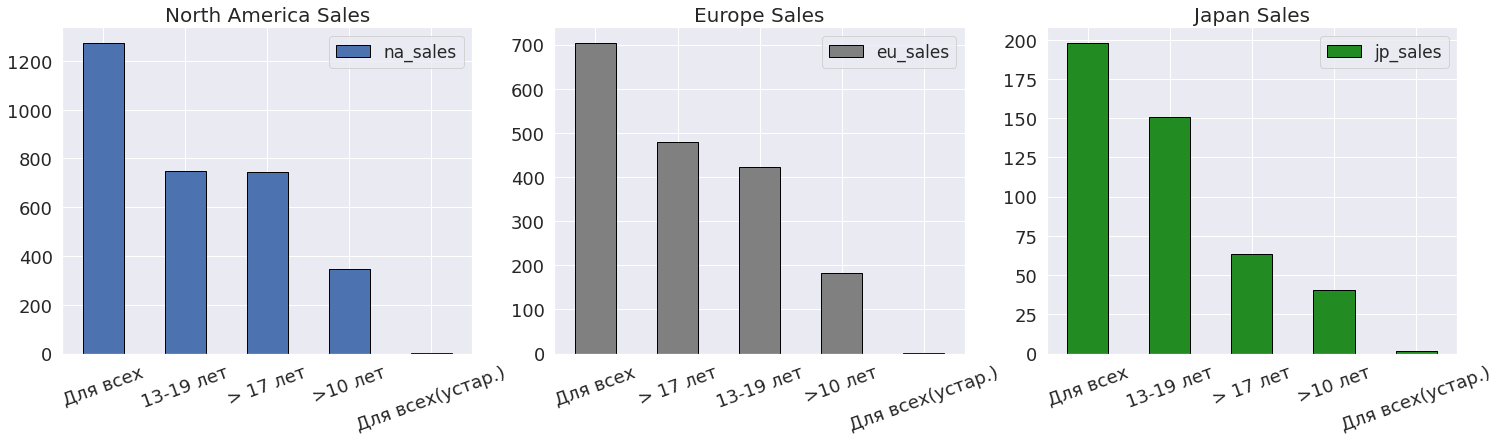

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot('ESRB_description', 'na_sales', 0)
top_in_regions_plot('ESRB_description', 'eu_sales', 1)
top_in_regions_plot('ESRB_description', 'jp_sales', 2)

В <b>Северной Америке</b> и в <b>Европе</b> картина практически одинаковая. Большая часть выручки получено с игр с рейтингом <b>"Для всех"</b>, поровну - с рейтингом <b>"13-19 лет"</b> и <b>"для лиц старше 17 лет"</b>.<br/><br/>
В <b>Японии</b> опять не так. Первое место такое же - <b>"Для всех"</b>, а вот на втором - игры для лиц <b>от 13 до 19 лет</b>. Да, там играют с раннего детства.

## Шаг 5. Проверка гипотез

<font size="3"><b>Гипотезы</b>:</font>
* средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> одинаковые;
* средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> разные.

Для проверки обеих гипотез будем использовать <b>t-критерий Стьюдента</b>, т.к. в обоих случаях выборки независимы между собой.<br/>
Определим пороговое значение alpha = 0.05

<br/><b>5.1. Гипотеза № 1</b>:<br/>
<b>средние пользовательские рейтинги платформ Xbox One и PC одинаковые</b>

<b>Н0 (нулевая гипотеза)</b> - средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> одинаковые.<br/>
<b>Н1 (альтернативная гипотеза)</b> - средние пользовательские рейтинги платформ <b>Xbox One</b> и <b>PC</b> отличаются между собой.

In [43]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total,ESRB_description
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,Для всех
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,Для всех
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,Для всех
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38,NaN


In [44]:
xbox_one_ratings = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)]['user_score']
pc_ratings = games[(games['platform'] == 'PC') & (games['user_score'] > 0)]['user_score']
stat, p = ttest_ind(xbox_one_ratings, pc_ratings)

print('t = {}\np-value = {:.10e}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = -4.38289526334195
p-value = 1.3037979620e-05

Пороговое значение alpha = 0.05


Смело отклоняем нулевую гипотезу.<br/>
Верно следующее утверждение: <b>средние пользовательские рейтинги платформ Xbox One и PC отличаются между собой.</b><br/><br/>
Посмотрим в чью пользу:

In [45]:
print('Средняя оценка пользователей игр для платформы Xbox One  - {:.2f}'.format(xbox_one_ratings.mean()))
print('Средняя оценка пользователей игр для платформы PC - {:.2f}'.format(pc_ratings.mean()))

Средняя оценка пользователей игр для платформы Xbox One  - 6.52
Средняя оценка пользователей игр для платформы PC - 7.07


Компьютерные игры получают оценки статистически значимо выше, чем игры для <b>Xbox One</b>. Неудивительно, <b>Xbox One</b> такого натерпелся в последнее время. Не зря у <b>Microsoft</b> осталась всего пара эксклюзивов - всё остальное ушло на <b>PlayStation</b>.

<br/><b>5.2. Гипотеза № 2</b>:<br/>
<b>средние пользовательские рейтинги жанров Action и Sports разные</b>.<br/>

<b>Н0 (нулевая гипотеза)</b> - средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> одинаковые.<br/>
<b>Н1 (альтернативная гипотеза)</b> - средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> отличаются между собой.

In [46]:
action_ratings = games[(games['genre'] == 'Action') & (games['user_score'] > 0)]['user_score']
pc_ratings = games[(games['genre'] == 'Sports') & (games['user_score'] > 0)]['user_score']
stat, p = ttest_ind(action_ratings, pc_ratings)

print('t = {}\np-value = {:.4f}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 1.8472797735322193
p-value = 0.0648

Пороговое значение alpha = 0.05


Не можем отвергнуть нулевую гипотезу.<br/>
Таким образом, остается верным утверждение, что <b>средние пользовательские рейтинги жанров <b>Action</b> и <b>Sports</b> одинаковые</b>.

## Шаг 6. Общий вывод

В ходе работы:

* ознакомились с предоставленными данными, выявили ошибки и пропуски в датасете и обработали их: привели названия столбцов к нижнему регистру, преобразовали данные в нужные типы, заполнили пропуски, посчитали суммарные продажи во всех регионах и добавили в датасет.

* провели исследовательский анализ данных, выделили срез данных за 2006-2016 гг

* нашли топ платформ-лидеров по продажам: X360, PS3, Wii, DS, PS4, PS2, 3DS, PSP, PC, XOne

Выяснили, что:

* В промежутке исследуемых 10-лет пик прибыли у большинства платформ приходится на 2008-2011 годы. Позднее выручка становится все меньше и меньше. Назвать потенциально прибыльной (учитывая, что в нашем распоряжении данные не за полный 2016 год) можно только платформу PS4.

* На примере PS3 рассмотрели корреляцию оценка критика/выручка и оценка пользователя/выручка и пришли к выводу, что отзывы критиков в большей степени влияют на продажи, чем отзывы пользователей.

* Самыми прибыльными оказались жанры Action, Sports и Shooter.

* Самые низкие сборы у жанров Adventure, Puzzle и Strategy.

* Составили портрет пользователей в Северной Америке, Европе и Японии:

**В Северной Америке и Европе картина примерно одинакова:**

лидируют платформы X360, Wii и DS, PS3 с небольшой разницей в распределении продаж.
самые популярные жанры - Action, Sports,Shooter, Misc
с большим отрывом по продажам лидирует рейтинг E (для всех), на втором месте M (18+)  

**В Японии немного по-другому:**

лидируют совсем другие платформы - 3DS, WiiU, DS, PSP, PS3
самые популярные жанры - Role-Playing, Platform, Sports, Misc, Action. В Японии популярные жанры выглядят более безобидно
самые большие продажи у рейтингов E (для всех) и T (для подростков). Похоже, в Японии выбирают более спокойные игры.
Другие страны:

* для остальных стран портрет потребителя примерно одинаков с потребителями из СА и Европы. Лидируют те же платформы, жанры и рейтинги. Выходит, Япония - достаточно специфический рынок, к которому нужен особый подход в плане рекламных кампаний.
Проверили следующие две гипотезы и отвергли обе (всё же разница между пользовательскими рейтингами платформ и жанров есть):

* средние пользовательские рейтинги платформ Xbox One и PC не равны, а
средние пользовательские рейтинги жанров Action и Sports равны.
* Планируя рекламную кампанию на 2017 год стоит обратить особое внимание на продвижение платформы PS4 (как более новую версию популярной PS3), а также платформ X360и Wii, и в особенности игр в жанрах Action, Sports, Shooter.

* Стоит также не забывать об особенностях рынка и подстроить рекламу конкретно под него. На примере Японии мы разобрали, как требования потребителей одной страны могут отличаться от предпочтений основной массы пользователей